In [2]:
import os
import sys
import copy

import numpy as np
import pandas as pd
import netCDF4 as nc

import warnings
warnings.filterwarnings('ignore')

BASE_PATH = '..'

sys.path.append(BASE_PATH)
os.chdir(BASE_PATH)

In [3]:
from core.clustering.static_clustering import StaticClustering

2024-10-16 15:13:31,743 - h5py._conv - DEBUG - Creating converter from 7 to 5
2024-10-16 15:13:31,743 - h5py._conv - DEBUG - Creating converter from 5 to 7
2024-10-16 15:13:31,744 - h5py._conv - DEBUG - Creating converter from 7 to 5
2024-10-16 15:13:31,744 - h5py._conv - DEBUG - Creating converter from 5 to 7


3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]


In [61]:
def verify_cluster_ok(image, i, j, cluster, size=7, min_purity=0.9):
    count = 0
    # Count how many points given the i, j are correct in the cluster
    for ii in range(i, i+size):
        for jj in range(j, j+size):
            if image[ii, jj] == cluster:
                count += 1
    
    purity = count / (size**2)
    return purity >= min_purity, purity

def find_bbox_for_cluster(image, cluster, size=7, purity=0.9):
    max_purity = 0
    purity = 0
    cluster_ok = False
    point = None

    for i in range(image.shape[0] - size):
        for j in range(image.shape[1] - size):
            if image[i, j] == cluster:
                cluster_ok, purity = verify_cluster_ok(image, i, j, cluster, size=size, min_purity=purity)

                if cluster_ok and purity > max_purity:
                    max_purity = purity
                    point = (j, i)
                        
            if purity == 1: break
        if purity == 1: break

    if point is None:
        print(f"Point for cluster {cluster} with putiry >= {purity} not found")
        return None, None
    
    return point, (point[0] + size, point[1] + size)

def find_points_for_clusters(image, size=7, purity=0.9):
    clusters = np.unique(image)
    print(f"Found {len(clusters)} clusters, with values {clusters}")
    points = []
    for cluster in clusters:
        point0, point1 = find_bbox_for_cluster(image, cluster, size=size, purity=purity)

        print(f"Cluster {cluster} found at {point0} and {point1}")
        if point0 is not None:
            points.append((point0, point1))    
    return points

In [4]:
base_path = './input/data/'
input_file = 'data_grid.nc'
data = nc.Dataset(os.path.join(base_path, input_file))

print(data.variables.keys())

dict_keys(['velocity', 'time', 'lat', 'lon'])


In [5]:
data = np.array(data['velocity'])

In [57]:
clustering = StaticClustering(data, 'parcorr4')
clustering.run()
clustering.save_clustering_image('./notebooks/', f"cluster_ogasawara")

2024-10-16 16:07:11,618 - core.clustering.parcorr - DEBUG - Vector sketches calculated


Found 4 clusters, with values [0 1 2 3]
Cluster 0 found at (0, 0) and (10, 10)
Cluster 1 found at (24, 18) and (34, 28)
Cluster 2 found at (0, 17) and (10, 27)
Cluster 3 found at (41, 0) and (51, 10)


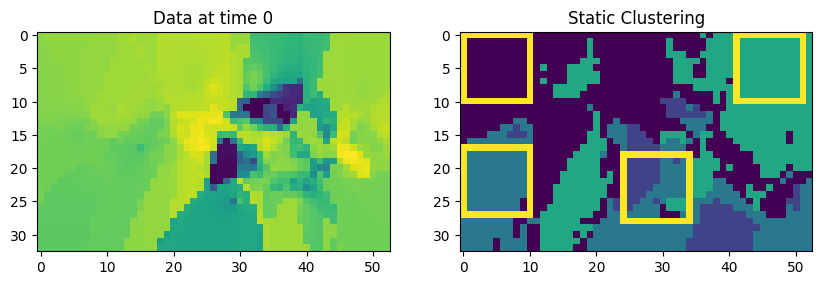

In [62]:
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

def build_box(image, point0, point1):
    color = [5]
    x = 1
    y = 0
    image[point0[x]:point1[x]+1, point0[y]] = color
    image[point0[x]:point1[x]+1, point1[y]] = color
    image[point0[x], point0[y]:point1[y]+1] = color
    image[point1[x], point0[y]:point1[y]+1] = color

    return image

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
t = 0
plt.title(f"Data at time {t}")
plt.imshow(data[t, :, :], cmap='viridis')

plt.subplot(1, 2, 2)
plt.title("Static Clustering")

image = copy.deepcopy(clustering.clustering_matrix)

# image = build_box(image, (0, 0), (7, 7)) # C1
# image = build_box(image, (20, 0), (27, 7)) # C2
# image = build_box(image, (35, 0), (42, 7)) # C3
# image = build_box(image, (0, 20), (7, 27)) # C4
# image = build_box(image, (35, 25), (42, 32)) # C5

points = find_points_for_clusters(image, size=10)

for point in points:
    image = build_box(image, point[0], point[1])

plt.imshow(image, cmap='viridis')

plt.show()